# Fairness Sandox

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
# uncomment as needed

# %pip install aif360
# %pip install fairlearn
# %pip install imbalanced-learn
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from numpy import percentile

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Data

### Dataset Class

In [3]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = [],
                 sens_attr = '', has_sens_attr = True,
                 sep = '', synthetic = False):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.has_sens_attr = has_sens_attr
        if has_sens_attr:
            self.sens_attr = sens_attr
        if not synthetic:
            self.df = pd.read_csv(path, sep = sep)

In [4]:
# collection of datasets is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        raise TypeError("Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

### Popular Datasets

In [5]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols_adult = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country','income']
num_cols_adult = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols_adult, num_cols_adult, sep = ",", sens_attr = 'race')

add_dataset(adult_income)

In [6]:
cat_cols_por = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num_cols_por = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_por", path='Datasets/student-por.csv',
                    cat_cols=cat_cols_por, num_cols=num_cols_por, sep = ";", sens_attr = 'sex'))

### Synthetic Data Generation

#### Helper Functions

In [7]:
# create binary sensitive attribute
def get_sensitive_feat(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    sens_feat = np.vstack((minority, majority))
    
    # shuffle so as to ensure randomness
    np.random.shuffle(sens_feat)
    
    return sens_feat

In [8]:
def get_cat_feats(num_cat_feats, cat_feats_levels, n):
    cat_feats = []
    for i in range(num_cat_feats):
        levels = cat_feats_levels[i]
        if levels < 2:
            raise ValueError("Categorical features must have at least 2 classes!")
        vals = np.arange(levels)
        cat = np.random.choice(vals, n, [0.5,0.5]).reshape(n, 1)
        cat_feats.append(cat)
    return np.hstack((cat_feats))

In [9]:
def distribution_plot(outcome_min = [], outcome_maj = [], outcome = [],
                      threshold_min = 0.5, threshold_maj = 0.5,
                      diff_dist = False):
    
    if diff_dist:

        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.hist(outcome_min,label='continuous outcome',bins='auto')
        plt.axvline(threshold_min,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Minority")

        plt.subplot(1,2,2)
        plt.hist(outcome_maj,label='continuous outcome',bins='auto')
        plt.axvline(threshold_maj,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Majority")
        plt.show()
        
    else:
        
        plt.figure(figsize=(17,7))
        plt.subplot(1,2,1)
        plt.hist(outcome,label='continuous outcome',bins='auto')
        plt.axvline(threshold_min,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Distribution of Outcomes")
        plt.show()

In [10]:
def get_attribute_names(df, num_numerical_cols, num_cat_cols):
    col_names = []
    for i in range(num_numerical_cols):
        col_names.append('num' + str(i+1))
    for i in range(num_cat_cols):
        col_names.append('cat' + str(i+1))
    col_names.append('sens_feat')
    col_names.append('outcome')
    
    return col_names

In [11]:
# flip labels with probability eta
def flip_labels(df_synthetic, label_noise):
    labels = df_synthetic['outcome']
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= label_noise:
            labels[i] = 1 if labels[i] == 0 else 0
    df_synthetic['outcome'] = labels
    
    return df_synthetic

#### Main Function

In [12]:
'''
Parameters:

    n is the total number of examples in the dataset
    
    num_numerical_feats is number of numerical features
        each numerical feature is drawn from a
        multivariate normal distribution with mean 0
        
    num_cat_feats is number of categorical features
    
    cat_levels is an array where each element is the number
        of levels for each categorical feature
        len(cat_levels) = num_cat_feats
        
    r is the proportion of examples in the minority group
        (1-r) is proportion of examples in majority group
        
    label_noise is in [0,1]
    
    diff_dist is true if minority and majority have different
        underlying sampling distributions
        
    show_vis displays the distribution of outcomes

'''

def get_synthetic_data(n, r, num_numerical_feats, num_cat_feats,
                       cat_levels = [], label_noise = 0, 
                       diff_dist = False, show_vis = False):
    
    assert 0 < r < 1, "R must be in [0,1]"
    num_min = int(n*r)
    num_maj = n - num_min
    
    cat_probs = list(np.multiply(np.ones(num_cat_feats),0.5))
    
    # numerical feature params
    means = list(np.zeros(num_numerical_feats))
    cov_matrix = list(np.identity(num_numerical_feats))
    
    # generating the features
    
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    num_features_maj = np.random.multivariate_normal(means, cov_matrix, num_maj)
    num_features = np.concatenate((num_features_min, num_features_maj))
        
    # binary sensitive attribute, 0: minority, 1: majority
    sens_feat = get_sensitive_feat(r=r, n=n) 
    
    assert len(cat_levels) == num_cat_feats, \
    "Each categorical feature must have a specification for its number of levels"
    cat_feats = get_cat_feats(num_cat_feats, cat_levels, n)
    
    # generating outcomes (continuous and binary)
    if diff_dist:
        # causal effect params
        effect_param_min = [0.5, -0.2, 0.1] 
        effect_param_maj = [-0.7, 0.5, 1.5]
        outcome_continuous_min = 1/(1+np.exp(-np.matmul(num_features_min,effect_param_min))) # logit model + no added noise
        outcome_continuous_maj = 1/(1+np.exp(-np.matmul(num_features_maj,effect_param_maj)))
        outcome_binary_min = np.where(outcome_continuous_min >= 0.5, 1, 0) # logistic decision boundary
        outcome_binary_maj = np.where(outcome_continuous_maj >= 0.5, 1, 0)
        outcome_binary = np.hstack((outcome_binary_min, outcome_binary_maj)).reshape(n,1)
        if show_vis:
            distribution_plot(outcome_continuous_min, outcome_continuous_maj, diff_dist=True)
    else:
        effect_param = [0.5, -0.2, 0.1] 
        outcome_continuous = 1/(1+np.exp(-np.matmul(num_features,effect_param))) # logit model + no added noise
        outcome_binary = np.where(outcome_continuous >= 0.5, 1, 0).reshape(n,1) # logistic decision boundary
        if show_vis:
            distribution_plot(outcome=outcome_continuous, diff_dist=False)

    
    temp_data = np.hstack((num_features, cat_feats, sens_feat, outcome_binary))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = get_attribute_names(df_synthetic, num_numerical_feats, num_cat_feats)
    
    assert 0 <= label_noise < 1, "Label noise must be in [0, 1)"
    if label_noise != 0:
        df_synthetic = flip_labels(df_synthetic, label_noise)
    
    # add to dictionary of datasets
    path_synthetic = 'Datasets/synthetic_data.csv'
    df_synthetic.to_csv(path_synthetic)
    add_dataset(Dataset('synthetic', path_synthetic, cat_cols=[], num_cols=[], synthetic=True, sens_attr = "sens_feat"))
    
    return df_synthetic

# example usage
df_synthetic = get_synthetic_data(1000, 0.25, 3, 2, [2,3], diff_dist=True, label_noise = 0.1)

# EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [13]:
# take a peek at the first few data points
df_synthetic.head()

,num1,num2,num3,cat1,cat2,sens_feat,outcome
0,1.912702,-0.297216,-0.319994,0.0,2.0,1.0,0.0
1,-0.375164,-1.676420,0.373247,1.0,0.0,1.0,0.0
2,0.668385,-0.154551,0.420657,0.0,2.0,1.0,1.0
3,-1.200333,0.003363,0.228082,0.0,0.0,0.0,1.0
4,-0.113505,-0.896567,-0.520676,0.0,0.0,1.0,0.0


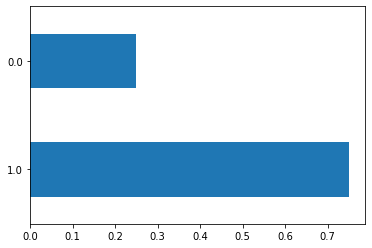

In [14]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
plot_counts(df_synthetic, 'sens_feat')

1.0
0.0


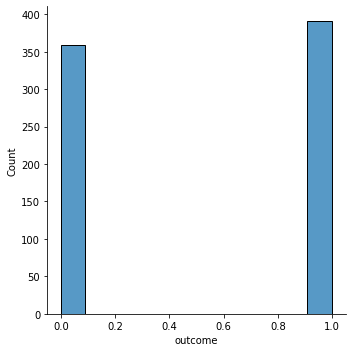

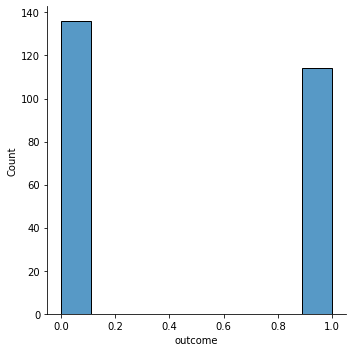

In [15]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
group_by_plot(df_synthetic, 'sens_feat', 'outcome')

# Preparation

### Train/Test Split

NOTES: 
1. Whether you input your own data, choose one of our provided datasets, or generate synthetic data, we will consider this to be the UNBIASED GROUND TRUTH.
2. Then, we will split the data, with the first part being the data which we will inject bias into and the second part being the unbiased ground truth testing data.



In [16]:
'''
    train_ratio: is the proportion of data examples in the training set
        (1-train_ratio is proportion in unbiased testing set)
'''
def train_test_split(df, train_ratio = 0.5):
    
    df_train = df.loc[range(0,int(len(df_synthetic)*train_ratio)), :]
    df_test = df_synthetic.loc[range(int(len(df_synthetic)*train_ratio)+1, len(df_synthetic)), :]
    
    return df_train, df_test

df_train, df_test = train_test_split(df_synthetic)

### Data Preprocessing

In [17]:
'''

This function separates the minority and majority classes

Parameters:
    
    sens_attr: sensitive attribute
    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class

'''
def get_maj_min(df, sens_attr, maj_val, min_val):
    assert sens_attr in list(df.columns), "Sensitive attribute must be a column in the dataframe!"
    df_majority = df_train[df_train[sens_attr] == maj_val]
    df_minority = df_train[df_train[sens_attr] == min_val]
    
    return df_majority, df_minority

df_majority, df_minority = get_maj_min(df_train, 'sens_feat', 1, 0)

#### One-Hot Encoding (ONLY for non-synthetic data)

In [18]:
# OHE categorical features (prompt for user's choice here?)

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

# df_train = pd.get_dummies(df_train, get_cat_cols(datasets['short_name']))

#### Formatting Data

In [19]:
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values

In [20]:
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

sens_attrs_true = [df_test[datasets['synthetic'].sens_attr]]

# Bias Injection (TODO - put different biases into another file?)

### List of Biases
1. Representation
2. Measurement
3. Omitted Variable
4. Label Noise
5. Over-Sampling (of Majority)
6. Under-Sampling (of Minority)

NOTE: if data is NOT synthetic, print out the dataframe to check the dummy variables, e.g. if you want to apply a bias to a categorical feature cat_feat with value x, then use `df[cat_feat_x] == 1`

#### Representation Bias

Under-sample an attribute conditioned on subgroups for that feature and/or subgroups for other feature(s)

Note: you will need to input $\beta$, which is the probability of deleting an example from the desired group.

In [21]:
from biases import representation

In [22]:
# Example Usage

print(len(df_train[(df_train['num1'] > 0) & (df_train['cat1'] == 0)]))
df_ex = representation(df_train, (df_train['num1'] > 0) & (df_train['cat1'] == 0), 0.5)
len(df_ex[(df_ex['num1'] > 0) & (df_ex['cat1'] == 0)])

120


67

In [23]:
'''

feat_conditions: conditions of data to undersample,
    input clauses as (df['column_name'] boolean) combined with & or |,
    e.g. (df['num1'] > 0) & (df['num1'] <= 1) & (df['cat1'] == 0)
beta: probability of deleting a sample


def representation(df, feat_conditions, beta):
    
    df_bias = df.copy()
    drop_idx = []

    for i in df_bias.index[feat_conditions]:
        if random.uniform(0,1) <= beta: drop_idx.append(i)
        
    return df_bias.drop(drop_idx)

'''

"\n\nfeat_conditions: conditions of data to undersample,\n    input clauses as (df['column_name'] boolean) combined with & or |,\n    e.g. (df['num1'] > 0) & (df['num1'] <= 1) & (df['cat1'] == 0)\nbeta: probability of deleting a sample\n\n\ndef representation(df, feat_conditions, beta):\n    \n    df_bias = df.copy()\n    drop_idx = []\n\n    for i in df_bias.index[feat_conditions]:\n        if random.uniform(0,1) <= beta: drop_idx.append(i)\n        \n    return df_bias.drop(drop_idx)\n\n"

#### Measurement Bias

Add noise to an attribute, either entirely or on various subgroups

Refer to [numpy.random documentation](https://numpy.org/doc/1.16/reference/routines.random.html) for types of sampling distributions for the noise.

Helper Functions:
1. Get unique values for categorical features
2. Get 5 number summary for numerical features

In [41]:
'''

# Precondition: feature MUST be categorical
def get_unique_cat(df, feature):
    arr = list(np.sort(df[feature].unique()))
    return arr

# Precondition: feature MUST be numerical
def get_summary_num(df, feature):
    res = dict()
    res['attribute'] = feature
    
    data_min, data_max = df[feature].min(), df[feature].max()
    res['min'] = data_min
    res['max'] = data_max
    
    quartiles = percentile(df[feature], [25,50,75])
    res['1st Quartile'] = quartiles[0]
    res['2nd Quartile'] = quartiles[1]
    res['3rd Quartile'] = quartiles[2]
    
    return res
'''

"\n\n# Precondition: feature MUST be categorical\ndef get_unique_cat(df, feature):\n    arr = list(np.sort(df[feature].unique()))\n    return arr\n\n# Precondition: feature MUST be numerical\ndef get_summary_num(df, feature):\n    res = dict()\n    res['attribute'] = feature\n    \n    data_min, data_max = df[feature].min(), df[feature].max()\n    res['min'] = data_min\n    res['max'] = data_max\n    \n    quartiles = percentile(df[feature], [25,50,75])\n    res['1st Quartile'] = quartiles[0]\n    res['2nd Quartile'] = quartiles[1]\n    res['3rd Quartile'] = quartiles[2]\n    \n    return res\n"

In [40]:
'''
def get_noise(df, feature, noise_dist, noise_dist_params):
    num_params = len(noise_dist_params)
    
    if num_params == 1:
        noise = noise_dist(noise_dist_params[0])
    elif num_params == 2:
        noise = noise_dist(noise_dist_params[0], noise_dist_params[1])
    elif num_params == 3:
        noise = noise_dist(noise_dist_params[0], noise_dist_params[1],
                           noise_dist_params[2])
    else:
        raise ValueError("check your parameters for the noise distribution!")
        
    return noise

# inject noise with probability noise_prob
def inject_noise_cat(df_noise, feature, noise_prob):
    # get unique values for feature (from training dataset)
    unique_vals = get_unique_cat(df_train, feature)
    for i in range(len(df_noise[feature])):
        # noise injection criteria
        if random.uniform(0,1) <= noise_prob:
            # perturb specific noise value
            df_noise[feature].iloc[i] = np.random.choice(unique_vals)
    
    return df_noise

# inject noise with probability noise_prob
def inject_noise_num(df_noise, feature, noise_prob,
                     noise_dist, noise_dist_params):
    for i in range(len(df_noise[feature])):
        # noise injection criteria
        if random.uniform(0,1) <= noise_prob:
            # perturb specific noise value
            df_noise[feature].iloc[i] += get_noise(df_noise, feature,
                                      noise_dist, noise_dist_params)
    
    return df_noise

def total_measurement(df, feature, feature_type, noise_prob,
                      noise_dist, noise_dist_params, subgroups):
    err_msg = "Error! feature_type must be either numeric or categorical"
    noise = get_noise(df, feature, noise_dist, noise_dist_params)
    
    if feature_type == 'categorical':
        return inject_noise_cat(df, feature, noise_prob)
    else:
        assert feature_type == 'numeric', err_msg
        return inject_noise_num(df, feature, noise_prob, 
                                noise_dist, noise_dist_params)

# NOTE: we assume that you have provided the proper parameters for each noise distribution call
#       for each subgroup (if applicable)
def subgroup_measurement(df, feature, feature_type, noise_prob,
                         noise_dist, noise_dist_params, subgroups):
    err_msg = "Must have as many noise_dist_param lists as number of categories for feature"
    err_msg_2 = "Error! feature_type must be either numeric or categorical"
    
    if feature_type == 'numeric':
        for i in range(len(subgroups)):
            lower, upper = subgroups[i]
            # isolate subgroup
            df_noise = df[(df[feature] >= lower) & (df[feature] <= upper)]
            # apply noise to subgroup
            df_noise = inject_noise_num(df_noise, feature, noise_prob,
                                        noise_dist, noise_dist_params[i])
            # modify subgroup in original dataframe
            df[(df[feature] >= lower) & (df[feature] <= upper)] = df_noise
    else:
        # maybe randomly select from get_unique_cat for the specific groups?
        assert feature_type == 'categorical', err_msg_2
        for i in range(len(subgroups)):
            # isolate subgroup
            df_noise = df[df[feature] == subgroups[i]]
            # apply noise to subgroup
            df_noise = inject_noise_cat(df_noise, feature, noise_prob)
            # modify subgroup in original dataframe
            df[df[feature] == subgroups[i]] = df_noise

    return df

'''

'''
feature: must be a column in the dataframe
feature_type: numeric or categorical
noise_dist: distribution function from np.random library
    e.g. np.random.beta, np.random.logistic, etc.
    
noise_dist_params: parameters for noise distribution
    e.g. if noise_dist == np.random.normal
        then noist_dist_params could be [0, 0.1], i.e. noise w/ mean 0 and sigma 0.1
    NOTE 1: make sure number of parameters is consistent with function documentation
            EXCLUDING the final param (length of column)
    NOTE 2: if using subgroups, noise_dist_params[i] should be a list of the parameters 
            for the noise distribution of subgroup[i]
        
noise_type: 0 if noise applied to entire attribute,
            1 if noise applied to subgroups
            
noise_prob: probability of applying noise to an example

subgroups: subgroups for feature
    if feature_type == numerical:
        subgroups[i] is a range of values (x, y) for subgroup i
    if feature_type == categorical:
        subgroups[i] is a single numerical value for subgroup i
            (refer to OHE if needed)

'''
'''
def measurement(df, feature, feature_type, noise_dist = np.random.normal, 
                noise_prob = 0.25, noise_dist_params = [0, 1],
                noise_type = 0, subgroups = []):
    
    assert noise_type in [0,1], "noise_type must be 0 or 1, see comments!"
    assert feature in list(df.columns), "feature must be a column in the dataframe!"
    
    df_bias = df.copy()
    
    if noise_type == 0:
        df_bias = total_measurement(df_bias, feature, feature_type, noise_prob,
                                             noise_dist, noise_dist_params, subgroups)
    else:
        df_bias = subgroup_measurement(df_bias, feature, feature_type, noise_prob,
                                       noise_dist, noise_dist_params, subgroups)
        
        
    return df_bias
'''

'\ndef measurement(df, feature, feature_type, noise_dist = np.random.normal, \n                noise_prob = 0.25, noise_dist_params = [0, 1],\n                noise_type = 0, subgroups = []):\n    \n    assert noise_type in [0,1], "noise_type must be 0 or 1, see comments!"\n    assert feature in list(df.columns), "feature must be a column in the dataframe!"\n    \n    df_bias = df.copy()\n    \n    if noise_type == 0:\n        df_bias = total_measurement(df_bias, feature, feature_type, noise_prob,\n                                             noise_dist, noise_dist_params, subgroups)\n    else:\n        df_bias = subgroup_measurement(df_bias, feature, feature_type, noise_prob,\n                                       noise_dist, noise_dist_params, subgroups)\n        \n        \n    return df_bias\n'

In [26]:
from biases import measurement

In [42]:
# example: adds different measurement bias to, e.g. num1 < 0 and num1 > 0
df_example = measurement(df=df_train, feature='num1', feature_type='numeric', 
                         noise_dist=np.random.normal, noise_prob=1,
                         noise_dist_params=[(20, 1), (50, 1)], noise_type=1, 
                         subgroups=[(-1, 0), (0, 1)])

# example: adds measurement bias to examples with cat2 == 2
print(df_train['cat2'].value_counts())
df_example = measurement(df_train, 'cat2', 'categorical', noise_prob=1, noise_type=1, subgroups=[2])
print(df_example['cat2'].value_counts())

# example: adds measurement bias to num1
df_example = measurement(df_train, 'num1', 'numeric', np.random.normal, noise_prob=1,
                         noise_dist_params=[40, 1], noise_type=0)

0.0    184
2.0    162
1.0    154
Name: cat2, dtype: int64
0.0    237
1.0    208
2.0     55
Name: cat2, dtype: int64


#### Omitted Variable

Note: if you choose to remove the sensitive feature, you will no longer be able to impose a fairness intervention! Resulting comparisons will simply be between regular ml models trained with and without the sensitive attribute.

In [23]:
# must input a Dataset object
def omitted_variable(df, short_name, col_to_del, is_sens_attr = False):
    assert col_to_del in list(df.columns), "Column to delete must be a column in the dataframe!"
    assert short_name in datasets.keys(), "Dataset with that short name doesn't exist!"
    
    if is_sens_attr:
        datasets[short_name].has_sens_attr = False
        
    return df.drop(col_to_del, axis = 1)

#### Label Noise Bias

add noise to labels for a specific subset of the data (conditioned on another feature or subgroup of another feature)

In [24]:
'''

feature: must be a column in the dataframe
feature_type: numeric or categorical
subgroup_val: subgroup value for feature
    if subgroup_type == numerical:
        subgroup is a range of values (x, y)
    if subgroup_type == categorical:
        subgroup is a single numerical value
            (refer to OHE if needed)

label_noise: flip labels with probability label_noise

'''
def label_noise(df, feature, feature_type, subgroup_val, label_noise):
    
    assert feature in list(df.columns), "feature must be a column in the dataframe!"
    
    err_msg = "Error! feature_type must be either numeric or categorical"
    
    df_bias = df.copy()
    
    if feature_type == 'numeric':
        lower, upper = subgroup_val
        df_bias = df_bias[(df_bias[feature] >= lower) &
                          (df_bias[feature] <= upper)]
    
    else:
        assert feature_type == 'categorical', err_msg
        df_bias = df_bias[df_bias[feature] == subgroup_val]
        
    labels = list(df_bias['outcome'])
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= label_noise:
            labels[i] = 1 if labels[i] == 0 else 0
    df_bias['outcome'] = labels
    
    if feature_type == 'numeric':
        lower, upper = subgroup_val
        df[(df[feature] >= lower) & (df[feature] <= upper)] = df_bias
    else:
        df[df[feature] == subgroup_val] = df_bias
    
    
    return df

#### Over-Sampling Majority Class

Note: you can either choose to randomly over-sample existing examples or generate new samples by interpolation using SMOTE and ADASYN

In [21]:
'''

Parameters:

    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class
    sens_attr: sensitive attribute
    over_amt: amount of over-sampling to be applied to majority
        e.g. over_amt = 2 means twice as many samples in majority

'''
def random_over_sampling(df_train, sens_attr, 
                         maj_val, min_val, over_amt = 2):
    df_majority = df_train[df_train[sens_attr] == maj_val]
    df_minority = df_train[df_train[sens_attr] == min_val]
    
    df_oversampled = df_majority.sample(int(over_amt)*len(df_majority), replace = True)
    
    # combine oversampled and original majority class to create dataset
    df_concat = pd.concat([df_oversampled,df_minority])
    
    return df_concat.sample(frac=1) # reshuffle rows of dataframe randomly

In [22]:
from imblearn.over_sampling import *
# to avoid warning
pd.options.mode.chained_assignment = None

'''

Parameters:

    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class
    sens_attr: sensitive attribute
    over_amt: amount of over-sampling to be applied to majority
        e.g. over_amt = 2 means twice as many samples in majority
    type: if 1 then SMOTE, if 2 then ADASYN

'''
def over_sampling(df_train, sens_attr, 
          maj_val, min_val, over_amt = 2, type = 1):
    
    assert type in [1,2], "Type must be 1 or 2, see comments!"
    
    cols = df_train.columns
    
    df_majority_X = df_train[df_train[sens_attr] == maj_val].drop('outcome', axis = 1)
    df_majority_y = df_train[df_train[sens_attr] == maj_val]['outcome']
    df_minority_X = df_train[df_train[sens_attr] == min_val].drop('outcome', axis = 1)
    df_minority_y = df_train[df_train[sens_attr] == min_val]['outcome']
    
    over_sample_amt = int(len(df_majority_X) * over_amt)
    
    # make original minority class into majority with label 0
    df_minority_flipped = df_minority_X.sample(over_sample_amt, replace = True)
    df_minority_flipped['outcome'] = np.zeros((len(df_minority_flipped),1))
    
    # make original majority have all label 0 (so it's the minority now)
    df_majority_X['outcome'] = np.ones((len(df_majority_X),1))
    df_majority = df_majority_X
    
    df_total = pd.concat([df_minority_flipped, df_majority])
    
    X_total = df_total.iloc[:, :-1].values
    y_total = df_total.iloc[:, -1].values
    
    if type == 1:
        over_sampler = SMOTE(random_state = 42, sampling_strategy = 'minority')
    else:
        over_sampler = ADASYN(random_state = 42, sampling_strategy = 'minority')
    
    X_total_resampled, y_total_resampled = over_sampler.fit_resample(X_total, y_total)
    
    df_res = pd.DataFrame(X_total_resampled)
    df_res['outcome'] = y_total_resampled
    df_res.columns = cols
    
    df_oversampled = df_res[df_res[sens_attr] == maj_val]
    oversampled_labels = df_majority_y.sample(len(df_oversampled), replace = True).values
    
    labels = oversampled_labels
        
    df_oversampled['outcome'] = labels
    
    # combine oversampled and original majority class to create dataset
    df_concat = pd.concat([df_oversampled,df_minority])
    
    return df_concat.sample(frac=1) # reshuffle rows of dataframe randomly

#### Under-Sampling Minority Class

Note 1: you will need to input $\beta$, which is the probability of deleting an example from the minority class. For example, if $\beta = 0.25$ then each example in the training data will be deleted with probability $0.25$, which will result in approximately $25\%$ of the total minority class examples being deleted.

Note 2: this method is equivalent to using representation bias on the minority

In [20]:
'''

This function performs the under-sampling bias injection

'''
def under_sample(df_minority, beta):
    X_min = df_minority.iloc[:, :].values
    cols = df_minority.columns
    
    # delete each example with probability beta
    for i in range(len(X_min)):
        if random.uniform(0,1) <= beta:
            X_min = np.delete(X_min, 0, axis=0)
    
    df_minority = pd.DataFrame(pd.DataFrame(X_min))
    df_minority.columns = cols
    return df_minority


'''

Parameters:

    beta: probability of deleting example from minority
    sens_attr: sensitive attribute
    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class

'''
def under_sampling(df_train, beta, sens_attr,
                    maj_val, min_val):
    df_majority = df_train[df_train[sens_attr] == maj_val]
    df_minority = df_train[df_train[sens_attr] == min_val]
    
    df_total = df_majority
    df_undersampled = under_sample(df_minority, beta)

    # combine undersampled and original majority class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1) # reshuffle rows of dataframe randomly

### Bias Selection

In [43]:
biases = dict()

def add_bias(bias_func, short_name):
    biases[short_name] = bias_func

# example usage
add_bias(under_sampling, 'under_sampling')
add_bias(omitted_variable, 'omitted_variable')
add_bias(random_over_sampling, 'random_over_sampling')
add_bias(over_sampling, 'over_sampling')
add_bias(label_noise, 'label_noise')
add_bias(measurement, 'measurement')
add_bias(representation, 'representation')

### Bias Injection

In [44]:
#df_bias = biases['under_sampling'](df_train, 0.5, 'sens_feat', 1, 0, True)
#df_bias = biases['omitted_variable'](df_train, 'synthetic', 'num1', is_sens_attr=False)
#df_bias = biases['random_over_sampling'](df_train, 'sens_feat', 1, 0, 2)
#df_bias = biases['over_sampling'](df_train, 'sens_feat', 1, 0, 2, type=2)
df_bias = biases['label_noise'](df_train, 'sens_feat', 'categorical', 1, 0.2)

# for fairness measures later
if datasets['synthetic'].has_sens_attr:
    df_sens = df_bias[datasets['synthetic'].sens_attr]

# format data
X_bias = df_bias.iloc[:, :-1].values
y_bias = df_bias.iloc[:, -1].values

# Model

### Model Selection + Training (TODO: modularize)

In [45]:
# modularize and add data struct of different ml techniques

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_bias, y_bias)
y_pred_bias = classifier_bias.predict(X_bias)
y_pred_bias_on_true = classifier_bias.predict(X_true)

sens_feat_true = df_test['sens_feat']
sens_feat_bias = df_sens

### Model Performance (TODO: modularize)

In [46]:
print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_pred_truth, y_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Accuracy of Ground Truth Model on Ground Truth Data:  0.7575150300601202
Accuracy of Biased Model on Biased Data:  0.73
Accuracy of Biased Model on Ground Truth Data:  0.6813627254509018


In [47]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(metrics=accuracy_score,y_true=y_true, y_pred=y_pred_truth, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_truth, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Overall Accuracy:  0.7575150300601202
Group Accuracy :  sens_feat
0.0    0.793103
1.0    0.746736
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.44288577154308617
Group Selection Rate :  sens_feat
0.0    0.405172
1.0    0.454308
Name: selection_rate, dtype: object


# Fairness Intervention

In [51]:
# preprocessing

from fairlearn.preprocessing import CorrelationRemover

remover = CorrelationRemover(sensitive_feature_ids=[5])
remover_df = CorrelationRemover(sensitive_feature_ids=['sens_feat'])

X_train_corr = remover.fit_transform(X_train)
df_corr = pd.DataFrame(remover_df.fit_transform(df_train))

df_temp = df_train.drop('sens_feat', axis=1)
df_corr.columns = df_temp.columns

In [34]:
constraints = [EqualizedOdds(), DemographicParity(), ErrorRateParity(),
               FalsePositiveRateParity(), TruePositiveRateParity()]

In [85]:
# Exponentiated Gradient
constraint = DemographicParity()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_bias, y_bias, sensitive_features = sens_feat_bias)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.6132264529058116


In [84]:
# Grid Search
constraint = DemographicParity()
mitigator_grid_bias = GridSearch(classifier_bias, constraint)
mitigator_grid_bias.fit(X_bias, y_bias, sensitive_features = sens_feat_bias)
y_pred_mitigated_grid_bias_on_true = mitigator_grid_bias.predict(X_true)

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_grid_bias_on_true, y_true))

Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.6132264529058116


In [83]:
# postprocessing

from fairlearn.postprocessing import ThresholdOptimizer

thresh_optim = ThresholdOptimizer(estimator=classifier_bias, constraints= 'equalized_odds', predict_method='auto')
thresh_optim.fit(X_bias, y_bias, sensitive_features=sens_feat_bias)
y_pred_thresh_on_true = thresh_optim.predict(X_true, sensitive_features=sens_feat_true)

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_thresh_on_true, y_true))

Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.6132264529058116


# Evaluation

In [74]:
print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_true, y_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.7695390781563126
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.6132264529058116


In [47]:
# Ground Truth Model + Fairness Intervention on Ground Truth Data

gm_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated_true, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print("\n")

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated_true, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Accuracy:  0.8216432865731463
Group Accuracy :  sens_feat
0.0    0.838462
1.0    0.815718
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.4729458917835671
Group Selection Rate :  sens_feat
0.0    0.469231
1.0    0.474255
Name: selection_rate, dtype: object


In [48]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated_bias_on_true, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated_bias_on_true, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

Overall Accuracy:  0.6833667334669339
Group Accuracy :  sens_feat
0.0    0.715385
1.0    0.672087
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.531062124248497
Group Selection Rate :  sens_feat
0.0    0.515385
1.0    0.536585
Name: selection_rate, dtype: object


# Trade-Off Visualization

In [62]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(bias_amts, classifier, X_true, y_true, 
                           df_train, sensitive_feature = "cat",
                           is_synthetic = False,
                           apply_fairness = False, verbose = False):
    
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    count = 0

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    for bias in bias_amts:
        
        df_bias = biases['over_sampling'](df_train, 'sens_feat', 1, 0, 2, type=2)
        df_sens = df_bias[sensitive_feature]

        # format data
        X_bias = df_bias.iloc[:, :-1].values
        y_bias = df_bias.iloc[:, -1].values
        
        if not is_synthetic:
            # OHE
            ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
            X_bias_true = np.array(ct.fit_transform(X_bias))
        else:
            X_bias_true = X_bias
        
        y_bias_true = df_bias.iloc[:, -1].values
        
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = DemographicParity()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        if verbose:
            print("Finished Iteration: ", count)
            count +=1

    return bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [63]:
def accuracy_visualizations(bias_amts,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()

In [64]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated):
    plt.figure(figsize=(17,7))
    plt.subplot(1,2,1)
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlabel("Amount of Bias (number of minority samples removed)")
    plt.ylabel("Accuracy Score")
    #plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
    plt.title("Accuracy of Biased Model (trained on biased data)")
    plt.legend()
    plt.show()

In [65]:
classifier = LogisticRegression()

bias_amts = np.divide(list(range(10,-1,-1)),10)

bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(bias_amts, classifier, X_true, y_true,
                       df_train, "sens_feat", is_synthetic=True,
                       apply_fairness=True, verbose=True)

Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10


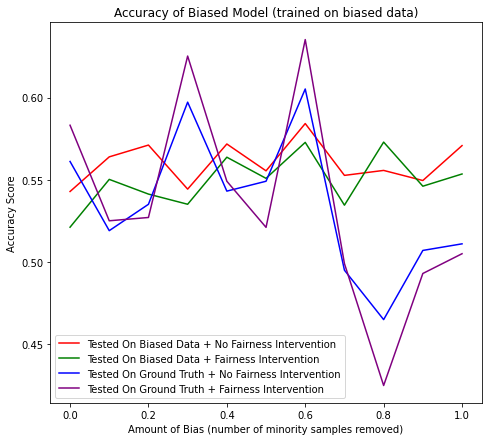

In [66]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                     accuracy_on_biased_mitigated, accuracy_on_true_mitigated)